In [1]:
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/kaggle/input/source')
#import file

import numpy as np
import os
import pandas as pd
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm


In [ ]:
DATASET = '../../zadanie2' #'../imgs'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4
BATCH_SIZE = 32#2#8#
IMAGE_SIZE = 416
NUM_CLASSES = 4 #classes to clasificate (vehicle,pedestrian,...)
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 12
CONF_THRESHOLD = 0.6
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
S_CONFIG = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
PIN_MEMORY = True
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_FILE = "checkpoint.pth.tar"
IMG_DIR = DATASET + "/images/"
LABEL_DIR = "../label/"
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  #between [0, 1]


scale = 1.1
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        # A.PadIfNeeded(
        #     min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        # ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[], check_each_transform=True),
)

CLASSES_LABELS = [
    "pedestrian",
    "car",
    "traffic light",
    "sign"
]

In [3]:
config1 = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["B", 8],
    # second route from the end of the previous block
    (1024, 3, 2),
    ["B", 4],
    # until here is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

In [4]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + self.use_residual * x

        return x

In [6]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes): #anchors_per_scale
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1),
        )
        self.num_classes = num_classes
        self.anchors_per_scale = 3 #anchors_per_scale

    def forward(self, x):
        return (
            self.pred(x)
                .reshape(x.shape[0], self.anchors_per_scale, self.num_classes + 5, x.shape[2], x.shape[3])
                .permute(0, 1, 3, 4, 2)
        )

In [7]:
print(config1)

[(32, 3, 1), (64, 3, 2), ['B', 1], (128, 3, 2), ['B', 2], (256, 3, 2), ['B', 8], (512, 3, 2), ['B', 8], (1024, 3, 2), ['B', 4], (512, 1, 1), (1024, 3, 1), 'S', (256, 1, 1), 'U', (256, 1, 1), (512, 3, 1), 'S', (128, 1, 1), 'U', (128, 1, 1), (256, 3, 1), 'S']


In [8]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs


    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config1:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(
                    ResidualBlock(
                        in_channels,
                        num_repeats=num_repeats,
                    )
                )

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes)
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(
                        nn.Upsample(scale_factor=2),
                    )
                    in_channels = in_channels * 3

        return layers

In [9]:
def test():
    num_classes = 4#20
    img_size = 416
    model = YOLOv3(num_classes=num_classes)

    x = torch.randn((2, 3, img_size, img_size))
    out = model(x)
    assert out[0].shape == (2, 3, img_size//32, img_size//32, 5 + num_classes)
    assert out[1].shape == (2, 3, img_size//16, img_size//16, 5 + num_classes)
    assert out[2].shape == (2, 3, img_size//8, img_size//8, 5 + num_classes)

test()

# Loss

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [10]:
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Constants
        self.lambda_class = 1
        self.lambda_noobj = 1
        self.lambda_obj = 1
        self.lambda_box = 1
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()


    def forward(self, predictions, target, anchors):
        obj = target[..., 0] == 1 
        noobj = target[..., 0] == 0
        no_object_loss = self.bce((predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),)
        anchors = anchors.reshape(1, 3, 1, 1, 2) # reshape anchors to allow for broadcasting in multiplication below
        # convert outputs from model to bboxes
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])
        # width and height to the same format as predictions
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        class_loss = self.entropy((predictions[..., 5:][obj]), (target[..., 5][obj].long()),)

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # na errory pri loadovani img

In [13]:
def check_bbox(bboxes):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
    #my added block 
    #bbox=list(bbox)
    for bbox in bboxes:
      print(bbox)
      for i in range(1):
        if (bbox[i]<0) :
              print(True)
        #  bbox[i]=0
        #elif (bbox[i]>1) :
        #  bbox[i]=1
        print((((bbox[3] + bbox[i]) / 2) / 416) < 0)
      #bbox=tuple(bbox)
   #end of block
   #rest of the code as it is

In [ ]:
def iou_width_height(boxes1, boxes2):
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]
        bboxes_after_nms.append(chosen_box)
    return bboxes_after_nms

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = CLASSES_LABELS
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    plt.show()

In [14]:
class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=4,#20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))
        #print(index, img_path, bboxes)
        #check_bbox(bboxes)
        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            #print("YoloDataset x,y: ",x, y)
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    #print(x_cell, y_cell)
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    #check_bbox(box_coordinates)
                    #print([x_cell, y_cell, width_cell, height_cell])
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction
        #print(targets)
        return image, tuple(targets)


Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  0


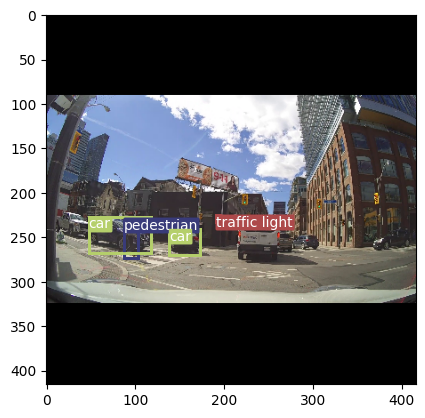

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  1


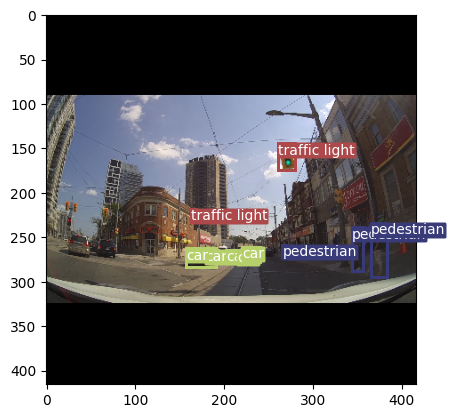

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  2


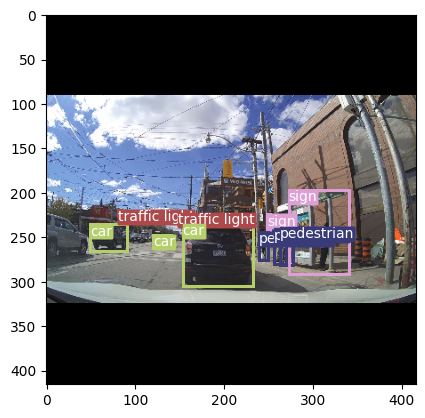

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  3


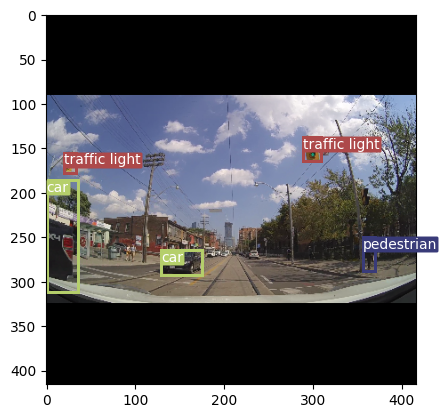

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  4


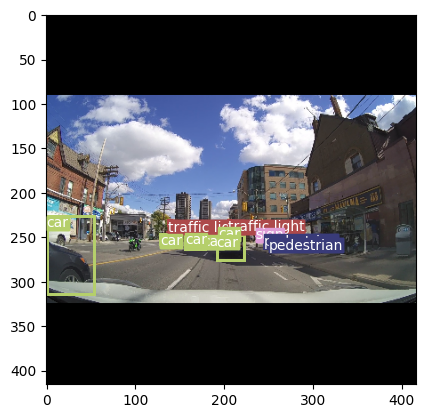

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  5


In [15]:
def test():
    anchors = ANCHORS

    transform = test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/train.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',#config.LABEL_DIR,
        S=S_CONFIG,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    #print(" : ",dataset.transform," : ")
    S = S_CONFIG #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    counter = 0
    for x, y in loader:
        #print("x,y: ",x,y)
        #print("A ",loader.__annotations__["dataset"])
        # pom1 = loader.sampler.data_source.annotations.values[72]
        # pom2 = loader.sampler.data_source.annotations.values[73]
        # pom3 = loader.sampler.data_source.annotations.values[74]
        # print("ADS ",pom1,pom2,pom3)
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        #print("BOXES: ",boxes)
        #print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


# if __name__ == "__main__":
test()

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  0


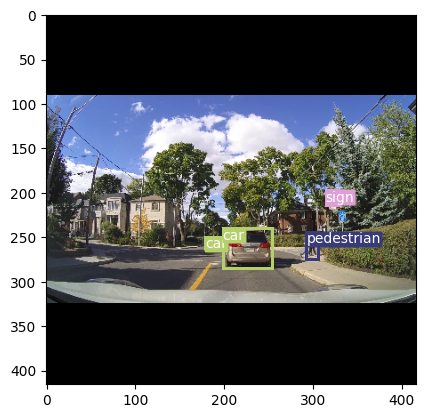

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  1


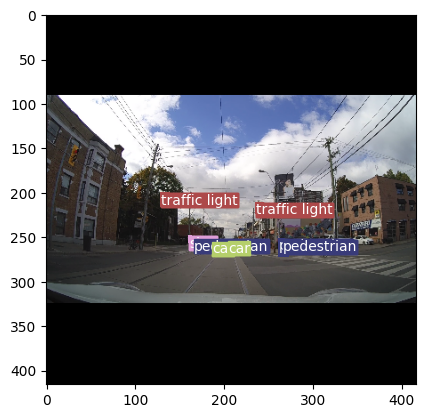

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  2


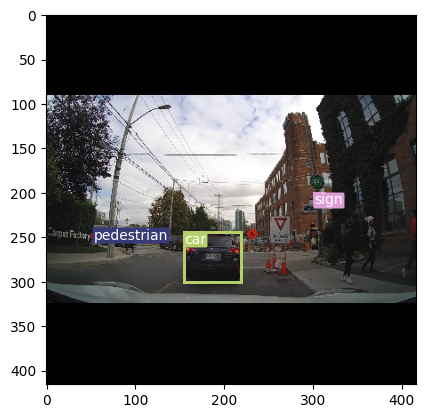

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  3


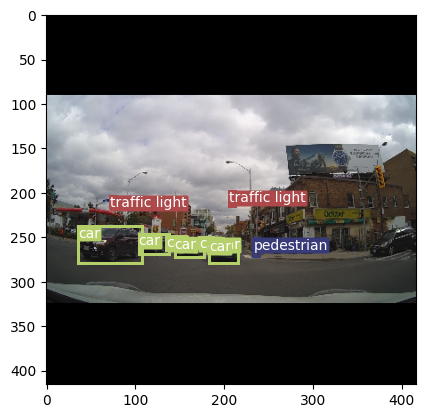

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  4


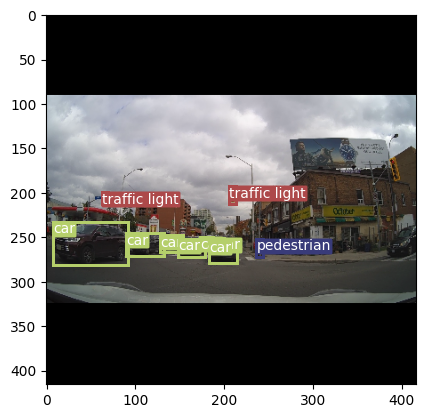

Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 13, 13, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 26, 26, 6])
Shape of anchor:  torch.Size([3, 2])
Loader y:  torch.Size([2, 3, 52, 52, 6])
Counter>  5


In [16]:
def test():
    anchors = ANCHORS

    transform = test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=S_CONFIG,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    #print(" : ",dataset.transform," : ")
    S = S_CONFIG #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True)
    counter = 0
    for x, y in loader:
        #print("x,y: ",x,y)
        #print("A ",loader.__annotations__["dataset"])
        # pom1 = loader.sampler.data_source.annotations.values[72]
        # pom2 = loader.sampler.data_source.annotations.values[73]
        # pom3 = loader.sampler.data_source.annotations.values[74]
        # print("ADS ",pom1,pom2,pom3)
        boxes = []
        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            print("Shape of anchor: ",anchor.shape)
            print("Loader y: ",y[i].shape)
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        print("Counter> ",counter)
        counter +=1
        if counter>5:
            break
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        #print("BOXES: ",boxes)
        #print(boxes)
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


# if __name__ == "__main__":
test()

# Training

In [17]:
import gc
#def report_gpu():
#print(torch.cuda.list_gpu_processes())
gc.collect()


15356

In [18]:
torch.cuda.empty_cache()

In [19]:
gc.collect()

0

In [1]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [20]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    return correct


def check_class_accuracy(y_hat, loader, threshold):
    #model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0
    for idx, (x, y) in enumerate(loader):
        if idx == 100:
           break
        x = x.float()
        x = x.to(DEVICE)
        with torch.no_grad():
            print(x.shape)
            out = y_hat(x)

    for i in range(3):
        y[i] = y[i].to(DEVICE)
        obj = y[i][..., 0] == 1 # in paper this is Iobj_i
        noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

        correct_class += torch.sum(
            torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
        )
        tot_class_preds += torch.sum(obj)

        obj_preds = torch.sigmoid(y_hat[i][..., 0]) > threshold
        correct_obj += accuracy_fn(y[i][..., 0][obj], obj_preds[obj]) #torch.sum(obj_preds[obj] == y[i][..., 0][obj])
        tot_obj += torch.sum(obj)
        correct_noobj += accuracy_fn(y[i][..., 0][noobj], obj_preds[noobj])#torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
        tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    #model.train()

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    average_precisions = [] # list storing all AP for respective classes
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        #skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))
    return sum(average_precisions) / len(average_precisions)


def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()


def get_evaluation_bboxes(loader,model,iou_threshold,anchors,threshold,box_format="midpoint",device=DEVICE):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)
        with torch.no_grad():
            predictions = model(x)
        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1
    model.train()
    return all_pred_boxes, all_true_boxes


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [23]:
torch.backends.cudnn.benchmark = True

def train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors): # scaler
    """
    Training
    """    
    #loop = tqdm(train_loader, leave=True)
    #print("A> ", enumerate(loop), " AHOJSTE",loop," <B")
    losses = []
    batches_counter = 0
    #epoch_train_true_action,epoch_train_total_action = 0,0

    for batch_idx, (x, y) in enumerate(train_loader): #enumerate(loop):
    #for x,y in train_loader:
        x = x.float()
        x = x.to(DEVICE)
        y0, y1, y2 = (
            y[0].to(DEVICE),
            y[1].to(DEVICE),
            y[2].to(DEVICE),
        )
        
        # clear the gradients
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            y_hat = model(x)
            loss = (
                loss_fn(y_hat[0], y0, scaled_anchors[0])
                + loss_fn(y_hat[1], y1, scaled_anchors[1])
                + loss_fn(y_hat[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        loss.backward()
        optimizer.step()
        
        # update train counters
        #epoch_train_loss += loss.item()

        # epoch_train_true_action += accuracy_fn(y_action_, y_batch_action)
        # epoch_train_total_action += len(y_batch_action)

        
        # update progress bar
        mean_loss = sum(losses) / len(losses)
        #loop.set_postfix(loss=mean_loss)
        print('loss', mean_loss)
        #print(batches_counter)
        batches_counter+=1



def main():
    model = YOLOv3(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    #scaler = torch.cuda.amp.GradScaler()

    # train_loader, test_loader, train_eval_loader = get_loaders(
    #     train_csv_path=config.DATASET + "/train.csv", test_csv_path=config.DATASET + "/train.csv"
    # )

    train_dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=0,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    val_dataset = YOLODataset(
        '/kaggle/input/mapping/val.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',#'../test.csv',
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        #img_dir=config.IMG_DIR,
        #label_dir=config.LABEL_DIR,
        anchors=ANCHORS,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=0,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    scaled_anchors = (
        torch.tensor(ANCHORS)
        * torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(DEVICE)
    epoch_counter = 0
    
    # init train lists for statistics
    loss_train, acc_train = list(), list()

    # init validation lists for statistics
    loss_val, acc_val = list(), list()
    
    # early stopper
    early_stopper = EarlyStopper(patience=3, min_delta=1)
    for epoch in range(NUM_EPOCHS):
        # init epoch train counters
        epoch_train_acc, epoch_train_total, \
            epoch_train_true, epoch_train_loss = 0, 0, 0, 0
        print(f"Currently epoch {epoch}")
        #train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
        train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors)

        if SAVE_MODEL:
            save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        #print("On Train Eval loader:")
        #check_class_accuracy(model, train_eval_loader, threshold=CONF_THRESHOLD)
        #print("On Train loader:")
        #check_class_accuracy(model, train_loader, threshold=CONF_THRESHOLD)
        
        val_fn(val_loader, model, optimizer, loss_fn, scaled_anchors)
        
        if epoch % 1 == 0:# and epoch > 0:
            print("On Test loader:")
            check_class_accuracy(model, val_loader, threshold=CONF_THRESHOLD)

            pred_boxes, true_boxes = get_evaluation_bboxes(
                val_loader,
                model,
                iou_threshold=NMS_IOU_THRESH,
                anchors=ANCHORS,
                threshold=CONF_THRESHOLD,
            )
            mapval = mean_average_precision(
                pred_boxes,
                true_boxes,
                iou_threshold=MAP_IOU_THRESH,
                box_format="midpoint", #midpoint originally
                num_classes=NUM_CLASSES,
            )
            print(f"MAP: {mapval.item()}")
        epoch_counter+=1



if __name__ == "__main__":
    main()


Currently epoch 0
loss 96.93254089355469
loss 76.47648429870605
loss 75.00209426879883
loss 69.27889347076416
loss 70.18508529663086
loss 66.39075152079265
loss 63.79825210571289
loss 65.04879331588745
loss 62.10457992553711
loss 59.57964515686035
loss 57.52462387084961
loss 56.10393492380778
loss 55.714401538555435
loss 54.30993298121861
loss 54.071546681722005
loss 53.3381085395813
loss 53.36521687227137
loss 52.78923670450846
loss 51.75677731162623
loss 51.091691970825195
loss 50.79746627807617
loss 50.101065375588156
loss 49.52679559458857
loss 48.84685802459717
loss 48.17299438476562
loss 47.682735443115234
loss 47.155914306640625
loss 46.690872056143625
loss 46.213775897848194
loss 45.98911196390788
loss 45.57971905123803
loss 45.25600457191467
loss 44.83248184666489
loss 44.60275683683508
loss 44.19820970807757
loss 43.938709047105576
loss 43.562171729835306
loss 43.233024195620885
loss 42.869802768413834
loss 42.538495254516604
loss 42.38496231451267
loss 42.09146708533878
loss

  0%|          | 0/371 [00:00<?, ?it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:02<03:12,  1.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:02<01:49,  3.33it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:02<01:21,  4.45it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:03<01:09,  5.17it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:03<01:04,  5.57it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:03<01:01,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:04<01:00,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:04<01:00,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:04<01:01,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:04<01:00,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:05<01:01,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:05<01:00,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:06<00:59,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:06<00:59,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 30/371 [00:06<00:59,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 33/371 [00:07<00:58,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:07<00:57,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:07<00:57,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 39/371 [00:08<00:57,  5.77it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:08<00:59,  5.60it/s]

torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:08<01:00,  5.47it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:09<00:57,  5.67it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:09<00:56,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:09<00:55,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:10<00:56,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:10<00:55,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:10<00:55,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:11<00:54,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:11<00:54,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:11<00:52,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:12<00:52,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:12<00:51,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:12<00:51,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:13<00:51,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:13<00:51,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:13<00:51,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:14<00:50,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:14<00:49,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:14<00:48,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:15<00:49,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:15<00:48,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:16<00:48,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:16<00:48,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▎       | 88/371 [00:16<00:48,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 90/371 [00:17<00:47,  5.89it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 92/371 [00:17<00:47,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:17<00:46,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 96/371 [00:18<00:46,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▋       | 98/371 [00:18<00:46,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:18<00:46,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:18<00:51,  5.30it/s]


Class accuracy is: 96.288994%
No obj accuracy is: 99.975166%
Obj accuracy is: 0.525452%


100%|██████████| 371/371 [01:31<00:00,  4.04it/s]


MAP: 0.002086660359054804
Currently epoch 1
loss 9.717422485351562
loss 10.436407089233398
loss 10.222405115763346
loss 10.271695375442505
loss 10.128530311584473
loss 10.010084629058838
loss 10.159188406808036
loss 10.100769758224487
loss 9.990392473008898
loss 10.003113651275635
loss 9.919882947748357
loss 9.841853300730387
loss 10.051707927997295
loss 10.328154972621373
loss 10.270971806844075
loss 10.210330605506897
loss 10.131035412059111
loss 10.120428032345242
loss 10.078469878748843
loss 10.049309492111206
loss 9.999194962637764
loss 9.965111082250422
loss 9.929632933243461
loss 9.909901142120361
loss 9.862544708251953
loss 9.853528022766113
loss 9.895604557461208
loss 9.847344023840767
loss 9.825755908571441
loss 9.802424208323162
loss 9.807151148396153
loss 9.84010374546051
loss 9.838404799952652
loss 9.83397949443144
loss 9.921892711094447
loss 9.907647609710693
loss 9.914590294296676
loss 9.913818685632004
loss 9.900587937770746
loss 9.932626509666443
loss 9.90642629018644


  0%|          | 0/371 [00:00<?, ?it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<01:05,  5.61it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<01:03,  5.83it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<01:01,  5.96it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<01:00,  6.01it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:01<01:00,  6.01it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<01:00,  6.05it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<01:00,  6.04it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<01:00,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:01,  5.84it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:02<01:01,  5.81it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:01,  5.85it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:01,  5.85it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:02<01:00,  5.86it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:00,  5.88it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:00,  5.87it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:00,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 19/371 [00:03<01:00,  5.77it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:01,  5.73it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:01,  5.70it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<01:01,  5.68it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:01,  5.64it/s]

torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<01:01,  5.64it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<01:01,  5.65it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<01:01,  5.65it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<01:00,  5.66it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 28/371 [00:04<01:00,  5.64it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:05<01:00,  5.61it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 30/371 [00:05<01:00,  5.61it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<01:00,  5.61it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 33/371 [00:05<01:08,  4.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<01:01,  5.48it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|█         | 38/371 [00:06<00:58,  5.65it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:07<00:58,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:56,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:55,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:08<00:55,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:55,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:55,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:55,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:56,  5.58it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▍        | 55/371 [00:09<00:56,  5.60it/s]

torch.Size([2, 3, 416, 416])


 15%|█▌        | 57/371 [00:10<00:57,  5.45it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 59/371 [00:10<00:55,  5.66it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▋        | 61/371 [00:10<00:52,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 63/371 [00:11<00:52,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 65/371 [00:11<00:52,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:52,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:12<00:52,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:52,  5.77it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:51,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:13<00:50,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 77/371 [00:13<00:49,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██▏       | 79/371 [00:13<00:49,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:14<00:48,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 83/371 [00:14<00:48,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<00:48,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:15<00:47,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:47,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:15<00:47,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:16<00:48,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:47,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 96/371 [00:16<00:52,  5.26it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▋       | 98/371 [00:17<00:50,  5.44it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.67it/s]


torch.Size([2, 3, 416, 416])
Class accuracy is: 99.310341%
No obj accuracy is: 99.997040%
Obj accuracy is: 10.738916%


100%|██████████| 371/371 [01:32<00:00,  3.99it/s]


MAP: 0.17428526282310486
Currently epoch 2
loss 5.307941913604736
loss 5.4693238735198975
loss 5.47596804300944
loss 5.768432259559631
loss 5.724014568328857
loss 5.691817045211792
loss 5.71464204788208
loss 5.669635355472565
loss 5.685580200619167
loss 5.693987607955933
loss 5.766555482690984
loss 5.799739996592204
loss 5.888807736910307
loss 5.871697664260864
loss 5.926107438405355
loss 5.909842938184738
loss 5.9273265670327575
loss 5.91605806350708
loss 5.895064203362716
loss 5.879154205322266
loss 5.855895769028437
loss 5.848170367154208
loss 5.847556010536525
loss 5.831465144952138
loss 5.815566577911377
loss 5.819057299540593
loss 5.793358679170962
loss 5.77940947668893
loss 5.816951209101184
loss 5.80032426516215
loss 5.8036824657071024
loss 5.855887249112129
loss 5.845471252094615
loss 5.840133933460011
loss 5.843034049442836
loss 5.833902319272359
loss 5.824727896097544
loss 5.80921715184262
loss 5.816430165217473
loss 5.812748074531555
loss 5.80099926925287
loss 5.79294639541

  0%|          | 1/371 [00:00<01:00,  6.13it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<00:59,  6.22it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<00:59,  6.21it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.12it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.16it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<01:05,  5.56it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:03,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:02<01:01,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:00,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:00,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<00:59,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<00:59,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<00:58,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<00:58,  5.89it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<00:58,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:04<00:59,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<00:59,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:05<00:58,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:06<00:58,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:59,  5.58it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 39/371 [00:06<00:59,  5.55it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:57,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:55,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:07<00:55,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 47/371 [00:08<00:54,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 50/371 [00:08<00:55,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:55,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:56,  5.67it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:54,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 57/371 [00:09<00:53,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:52,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:51,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:51,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<00:52,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:11<00:51,  5.82it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<00:55,  5.36it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:52,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:12<00:50,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 77/371 [00:13<00:49,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██▏       | 79/371 [00:13<00:48,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:13<00:48,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 83/371 [00:14<00:47,  6.03it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<00:47,  6.04it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:14<00:47,  6.01it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:46,  6.05it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:15<00:46,  6.03it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:15<00:46,  6.01it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:46,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:16<00:46,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:16<00:46,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:46,  5.78it/s]


torch.Size([2, 3, 416, 416])
Class accuracy is: 99.704430%
No obj accuracy is: 99.975311%
Obj accuracy is: 22.791462%


100%|██████████| 371/371 [01:40<00:00,  3.70it/s]


MAP: 0.24000012874603271
Currently epoch 3
loss 4.430668354034424
loss 4.432788610458374
loss 4.243536154429118
loss 4.160310387611389
loss 4.1914928436279295
loss 4.166315158208211
loss 4.145611694880894
loss 4.138984262943268
loss 4.117418395148383
loss 4.229887390136719
loss 4.208476630124179
loss 4.228835781415303
loss 4.240148691030649
loss 4.221408009529114
loss 4.208566904067993
loss 4.206893429160118
loss 4.211321367936976
loss 4.247583058145311
loss 4.242134081689935
loss 4.236362493038177
loss 4.2267432780492875
loss 4.2108199488032945
loss 4.201397263485452
loss 4.228101799885432
loss 4.222450208663941
loss 4.271124555514409
loss 4.257252083884345
loss 4.271139357771192
loss 4.255596547291197
loss 4.244234609603882
loss 4.228037295802947
loss 4.220243021845818
loss 4.2266905091025615
loss 4.210586232297561
loss 4.22277329989842
loss 4.209655463695526
loss 4.198142670296334
loss 4.20587306273611
loss 4.205470072917449
loss 4.197520184516907
loss 4.187503041290656
loss 4.18274

  0%|          | 1/371 [00:00<01:01,  6.01it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<01:01,  6.05it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<01:00,  6.11it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.13it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.15it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:59,  6.16it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:59,  6.15it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<01:00,  6.04it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<01:00,  5.99it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:00,  5.93it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:00,  5.91it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:01<01:01,  5.88it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:01,  5.84it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.86it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:02<01:00,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:01,  5.80it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:01,  5.78it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 19/371 [00:03<01:00,  5.77it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.80it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<00:59,  5.84it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:00,  5.80it/s]

torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<00:59,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<01:00,  5.75it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<00:59,  5.77it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 28/371 [00:04<00:59,  5.75it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:04<00:59,  5.77it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 30/371 [00:05<01:00,  5.64it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<01:00,  5.63it/s]

torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<01:00,  5.60it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 33/371 [00:05<01:01,  5.54it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:06<00:59,  5.62it/s]

torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:58,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|█         | 38/371 [00:06<00:58,  5.71it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 39/371 [00:06<00:58,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 41/371 [00:07<00:57,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:57,  5.71it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 43/371 [00:07<00:59,  5.48it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 45/371 [00:07<00:58,  5.55it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:07<00:57,  5.68it/s]

torch.Size([2, 3, 416, 416])


 13%|█▎        | 47/371 [00:08<00:56,  5.73it/s]

torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:56,  5.77it/s]

torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:55,  5.76it/s]

torch.Size([2, 3, 416, 416])


 13%|█▎        | 50/371 [00:08<00:55,  5.77it/s]

torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:55,  5.77it/s]

torch.Size([2, 3, 416, 416])


 14%|█▍        | 52/371 [00:09<00:55,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:55,  5.72it/s]

torch.Size([2, 3, 416, 416])


 15%|█▍        | 54/371 [00:09<00:55,  5.71it/s]

torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:55,  5.72it/s]

torch.Size([2, 3, 416, 416])


 15%|█▌        | 57/371 [00:09<00:53,  5.82it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:53,  5.84it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 59/371 [00:10<00:52,  5.90it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:52,  5.96it/s]

torch.Size([2, 3, 416, 416])


 16%|█▋        | 61/371 [00:10<00:51,  5.96it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  5.96it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 63/371 [00:10<00:51,  6.00it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:51,  5.97it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 65/371 [00:11<00:51,  5.91it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:52,  5.86it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 67/371 [00:11<00:51,  5.86it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<00:51,  5.87it/s]

torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:11<00:51,  5.85it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:51,  5.83it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<00:51,  5.82it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:12<00:51,  5.84it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:50,  5.90it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:12<00:49,  5.96it/s]

torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:12<00:49,  5.99it/s]

torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:13<00:49,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:55,  5.26it/s]

torch.Size([2, 3, 416, 416])


 21%|██▏       | 79/371 [00:13<00:58,  4.99it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:13<00:59,  4.88it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:14<01:00,  4.80it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<01:00,  4.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<00:53,  5.39it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:15<00:50,  5.66it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:48,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:15<00:47,  5.89it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:16<00:46,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:16<00:47,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:16<00:48,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:17<00:47,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.67it/s]


torch.Size([2, 3, 416, 416])
Class accuracy is: 99.901482%
No obj accuracy is: 99.967407%
Obj accuracy is: 44.499180%


100%|██████████| 371/371 [01:42<00:00,  3.63it/s]


MAP: 0.42141637206077576
Currently epoch 4
loss 3.1323928833007812
loss 3.027410387992859
loss 3.1677610874176025
loss 3.255380094051361
loss 3.2828225612640383
loss 3.366545836130778
loss 3.3315365655081615
loss 3.316600263118744
loss 3.2798866430918374
loss 3.273269438743591
loss 3.406819321892478
loss 3.4150928060213723
loss 3.393030936901386
loss 3.3897615500858853
loss 3.367285950978597
loss 3.3768217712640762
loss 3.3683379537918987
loss 3.35736522409651
loss 3.3390877874274003
loss 3.352410078048706
loss 3.352223441714332
loss 3.352777437730269
loss 3.3338032390760337
loss 3.3515779773394265
loss 3.3509104156494143
loss 3.341657666059641
loss 3.337714424839726
loss 3.3207205023084367
loss 3.333323676010658
loss 3.3251251379648843
loss 3.319437280777962
loss 3.3651896491646767
loss 3.3696202437082925
loss 3.3731100769603954
loss 3.363134643009731
loss 3.378954609235128
loss 3.3716462882789404
loss 3.3747705660368266
loss 3.3930020943666115
loss 3.3827880740165712
loss 3.374869695

  1%|          | 2/371 [00:00<01:10,  5.22it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<01:02,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:01<01:00,  6.05it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<00:59,  6.05it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:00,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:00,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:00,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<01:00,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<00:59,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<00:59,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<00:59,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:04<00:59,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<00:59,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:05<00:58,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:58,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:57,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:06<00:57,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 41/371 [00:07<00:57,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:56,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:07<00:55,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:55,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:55,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:55,  5.77it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:55,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:55,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 57/371 [00:09<00:54,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 59/371 [00:10<00:55,  5.65it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:59,  5.21it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:58,  5.31it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 63/371 [00:11<00:58,  5.31it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 65/371 [00:11<00:57,  5.28it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:56,  5.42it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<00:54,  5.59it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<00:52,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:51,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:13<00:50,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 77/371 [00:13<00:49,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██▏       | 79/371 [00:13<00:49,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:14<00:48,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 83/371 [00:14<00:48,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<00:48,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:15<00:47,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:15<00:47,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:16<00:46,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:46,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 96/371 [00:16<00:46,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:17<00:46,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.72it/s]


torch.Size([2, 3, 416, 416])
Class accuracy is: 99.967155%
No obj accuracy is: 99.968910%
Obj accuracy is: 51.330048%


100%|██████████| 371/371 [01:41<00:00,  3.65it/s]


MAP: 0.512484073638916
Currently epoch 5
loss 2.678720712661743
loss 2.6722458600997925
loss 2.6634910106658936
loss 2.620028793811798
loss 2.638729524612427
loss 2.6230543851852417
loss 2.7247989177703857
loss 2.7131883203983307
loss 2.742347478866577
loss 2.802881050109863
loss 2.788474668156017
loss 2.816817323366801
loss 2.815976326282208
loss 2.804060595376151
loss 2.8365683873494465
loss 2.850947991013527
loss 2.8465605483335605
loss 2.854723440276252
loss 2.8739358374946997
loss 2.8589239597320555
loss 2.860765354973929
loss 2.8579130281101572
loss 2.8669490295907725
loss 2.8534396588802338
loss 2.8519972133636475
loss 2.8397319867060733
loss 2.8372230706391512
loss 2.8253825221742903
loss 2.8159527943052094
loss 2.809797747929891
loss 2.801753367147138
loss 2.7906957641243935
loss 2.7933648644071636
loss 2.7895850083407234
loss 2.7984084129333495
loss 2.814395566781362
loss 2.8134858865995667
loss 2.825350698671843
loss 2.8306126716809397
loss 2.8260789275169373
loss 2.82894509

  0%|          | 1/371 [00:00<00:58,  6.27it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<00:58,  6.26it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<00:59,  6.23it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.22it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.19it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:59,  6.09it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:59,  6.07it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<00:59,  6.08it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<01:00,  6.00it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:00,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:01,  5.87it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:02<01:02,  5.74it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:02,  5.71it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:02<01:01,  5.76it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:01,  5.78it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:01,  5.78it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:01,  5.77it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 19/371 [00:03<01:01,  5.75it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.79it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:00,  5.78it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<01:00,  5.78it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:00,  5.77it/s]

torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<00:59,  5.81it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<00:59,  5.81it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<00:59,  5.83it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<00:59,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:05<01:07,  5.07it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<01:05,  5.18it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 33/371 [00:05<01:04,  5.28it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:06<01:02,  5.39it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<01:01,  5.42it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:07<00:59,  5.59it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 41/371 [00:07<00:58,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 43/371 [00:07<00:57,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:08<00:56,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:55,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:56,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:56,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:55,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:54,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:53,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:52,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  6.02it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:51,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:51,  5.89it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<00:51,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:12<00:52,  5.80it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:58,  5.14it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<01:01,  4.89it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:12<01:04,  4.62it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<01:05,  4.58it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:13<01:04,  4.61it/s]

torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:13<00:58,  5.01it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:53,  5.46it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:14<00:51,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<00:49,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:14<00:48,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:15<00:47,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▎       | 88/371 [00:15<00:47,  5.92it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:47,  5.89it/s]

torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:16<00:51,  5.43it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:16<00:49,  5.67it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:47,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:17<00:47,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:17<00:46,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:48,  5.61it/s]


torch.Size([2, 3, 416, 416])
Class accuracy is: 100.000000%
No obj accuracy is: 99.957153%
Obj accuracy is: 65.385880%


100%|██████████| 371/371 [01:43<00:00,  3.60it/s]


MAP: 0.5641344785690308
Currently epoch 6
loss 2.8392601013183594
loss 2.9319424629211426
loss 2.8078861236572266
loss 2.82966947555542
loss 2.9231067657470704
loss 2.8572658697764077
loss 2.7929439544677734
loss 2.7243094444274902
loss 2.8345890045166016
loss 2.8195560455322264
loss 2.810242089358243
loss 2.7839566469192505
loss 2.7484728006216197
loss 2.7307500498635426
loss 2.7060929616292317
loss 2.6948623955249786
loss 2.696283172158634
loss 2.6952357292175293
loss 2.6933284056814095
loss 2.6774000763893127
loss 2.655549855459304
loss 2.661116849292408
loss 2.641955209814984
loss 2.634441077709198
loss 2.6280039405822753
loss 2.6268456165607157
loss 2.6237524527090565
loss 2.6133424384253368
loss 2.605297795657454
loss 2.6123262008031207
loss 2.6083349104850524
loss 2.6125341057777405
loss 2.6048489700664175
loss 2.6211566854925716
loss 2.6163596834455216
loss 2.612245864338345
loss 2.6214766373505465
loss 2.616031709470247
loss 2.616181630354661
loss 2.6147482872009276
loss 2.606

  0%|          | 1/371 [00:00<00:59,  6.25it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<00:59,  6.16it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<00:59,  6.16it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.15it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.12it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:59,  6.16it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:59,  6.13it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<00:59,  6.07it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<01:00,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:01,  5.83it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:02<01:01,  5.87it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:01,  5.87it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.88it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:02<01:00,  5.85it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:00,  5.87it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:00,  5.85it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:00,  5.83it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 19/371 [00:03<01:00,  5.85it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<01:00,  5.78it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:00,  5.78it/s]

torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<00:59,  5.79it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<00:59,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<01:00,  5.74it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 28/371 [00:04<00:59,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 30/371 [00:05<00:59,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<00:59,  5.68it/s]

torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<01:00,  5.57it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:05<00:59,  5.65it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:06<00:59,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:58,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|█         | 38/371 [00:06<00:59,  5.58it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:06<00:58,  5.62it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 41/371 [00:07<00:58,  5.66it/s]

torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:57,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:56,  5.74it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:07<00:59,  5.47it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 47/371 [00:08<00:58,  5.58it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:58,  5.49it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:58,  5.49it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:58,  5.48it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:55,  5.64it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:53,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:52,  5.89it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:51,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:52,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<00:52,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:52,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<00:53,  5.64it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:12<00:51,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:13<00:51,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:50,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:13<00:49,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<00:48,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:14<00:48,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:14<00:47,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▎       | 88/371 [00:15<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 90/371 [00:15<00:47,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 92/371 [00:15<00:46,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:16<00:46,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:46,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▋       | 98/371 [00:16<00:46,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:46,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.74it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.975922%
Obj accuracy is: 71.855507%


100%|██████████| 371/371 [01:41<00:00,  3.65it/s]


MAP: 0.6713685393333435
Currently epoch 7
loss 2.5249083042144775
loss 2.2739115953445435
loss 2.3149730364481607
loss 2.253550887107849
loss 2.3413514137268066
loss 2.3828490177790322
loss 2.4159489018576488
loss 2.3697772324085236
loss 2.386031495200263
loss 2.3493642091751097
loss 2.3478821841153232
loss 2.3545151154200235
loss 2.3776659965515137
loss 2.3863295827593123
loss 2.368542544047038
loss 2.3630291670560837
loss 2.355298827676212
loss 2.353081915113661
loss 2.3486146173979106
loss 2.342854928970337
loss 2.3483247870490667
loss 2.347385211424394
loss 2.335797351339589
loss 2.321565791964531
loss 2.310917925834656
loss 2.3228351382108836
loss 2.3193296547289246
loss 2.317908546754292
loss 2.3354944566200517
loss 2.330378544330597
loss 2.3252186275297597
loss 2.335949417203665
loss 2.335548021576621
loss 2.3392673906157997
loss 2.340365481376648
loss 2.3347776962651148
loss 2.334373168043188
loss 2.3304044227851066
loss 2.331382033152458
loss 2.3326673418283463
loss 2.33324465

  0%|          | 1/371 [00:00<00:58,  6.30it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<01:00,  6.15it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<01:00,  6.11it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.12it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.14it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:59,  6.11it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:59,  6.15it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<00:59,  6.14it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<00:59,  6.04it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:00,  6.01it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:00,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])

  3%|▎         | 12/371 [00:02<01:04,  5.56it/s]

  4%|▍         | 14/371 [00:02<01:04,  5.51it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:02,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:01,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<01:00,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<00:59,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<00:59,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 28/371 [00:04<00:59,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:04<00:59,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<00:59,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:05<00:59,  5.67it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:58,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|█         | 38/371 [00:06<00:58,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 39/371 [00:06<00:59,  5.60it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:57,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:56,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:07<00:55,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:55,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 50/371 [00:08<00:55,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 52/371 [00:08<00:55,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:55,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:54,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:52,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:51,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  6.04it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 63/371 [00:10<00:50,  6.05it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 65/371 [00:11<00:59,  5.14it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<01:02,  4.90it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 67/371 [00:11<01:03,  4.79it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<01:04,  4.69it/s]

torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:12<01:05,  4.64it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:12<00:55,  5.35it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:53,  5.53it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:13<00:57,  5.12it/s]

torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:13<00:55,  5.35it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:51,  5.66it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:14<00:49,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<00:48,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:14<00:48,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:15<00:47,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▎       | 88/371 [00:15<00:47,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 90/371 [00:15<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 92/371 [00:16<00:47,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:16<00:47,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:47,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:17<00:47,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:17<00:48,  5.61it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.65it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.975876%
Obj accuracy is: 75.008209%


100%|██████████| 371/371 [01:42<00:00,  3.63it/s]


MAP: 0.7497121095657349
Currently epoch 8
loss 2.7710394859313965
loss 2.6011117696762085
loss 2.648427406946818
loss 2.7464420795440674
loss 2.8273970603942873
loss 2.806992252667745
loss 2.7419024194989885
loss 2.6979846358299255
loss 2.673493597242567
loss 2.638674736022949
loss 2.652485413984819
loss 2.7144184907277427
loss 2.693585670911349
loss 2.6533988203321184
loss 2.667804145812988
loss 2.671501561999321
loss 2.6473378994885612
loss 2.643297447098626
loss 2.626543308559217
loss 2.6162956595420837
loss 2.6147087074461437
loss 2.5939200899817725
loss 2.579159000645513
loss 2.554168929656347
loss 2.5303681564331053
loss 2.5324340233436
loss 2.5140932930840387
loss 2.5022787622043063
loss 2.4771160627233573
loss 2.5205509702364606
loss 2.529291118344953
loss 2.5092615336179733
loss 2.5097002043868555
loss 2.5080131152096916
loss 2.5077082702091764
loss 2.503786345322927
loss 2.4959930729221655
loss 2.4871138522499487
loss 2.501955454166119
loss 2.4951668679714203
loss 2.494237010

  0%|          | 1/371 [00:00<00:59,  6.18it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<00:59,  6.16it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<00:59,  6.22it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.21it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:58,  6.24it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:58,  6.20it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:59,  6.15it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<00:59,  6.11it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<00:59,  6.04it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:00,  5.98it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:00,  5.94it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:01<01:00,  5.93it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:00,  5.89it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.89it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:02<01:00,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 19/371 [00:03<01:00,  5.84it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.84it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 22/371 [00:03<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:00,  5.74it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<00:59,  5.78it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<00:59,  5.80it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<00:59,  5.81it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 28/371 [00:04<00:59,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:04<00:59,  5.77it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 30/371 [00:05<00:59,  5.70it/s]

torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<01:00,  5.61it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 33/371 [00:05<00:59,  5.67it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:05<00:59,  5.69it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:05<00:58,  5.70it/s]

torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:58,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:58,  5.71it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 39/371 [00:06<00:58,  5.70it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:06<01:02,  5.32it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:59,  5.50it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 45/371 [00:07<00:57,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 47/371 [00:08<00:56,  5.77it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:55,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 50/371 [00:08<00:55,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:55,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▍        | 54/371 [00:09<00:55,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 57/371 [00:09<00:53,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 59/371 [00:10<00:52,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▋        | 61/371 [00:10<00:51,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 63/371 [00:10<00:51,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 65/371 [00:11<00:52,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:51,  5.87it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:11<00:51,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<00:51,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:50,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:12<00:50,  5.89it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 77/371 [00:13<00:49,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██▏       | 79/371 [00:13<00:48,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:13<00:48,  5.93it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 83/371 [00:14<00:48,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:14<00:47,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:15<00:46,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:15<00:46,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:46,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:16<00:46,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:16<00:46,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:46,  5.79it/s]


torch.Size([2, 3, 416, 416])
Class accuracy is: 100.000000%
No obj accuracy is: 99.983635%
Obj accuracy is: 80.558296%


100%|██████████| 371/371 [01:40<00:00,  3.69it/s]


MAP: 0.8135079145431519
Currently epoch 9
loss 2.5607898235321045
loss 2.1750904321670532
loss 2.1318747997283936
loss 2.0378360748291016
loss 2.016733980178833
loss 1.956410010655721
loss 1.9795164380754744
loss 2.060583233833313
loss 2.0614808665381537
loss 2.026055908203125
loss 2.0692186138846655
loss 2.063159088293711
loss 2.0539002968714786
loss 2.069312027522496
loss 2.0421246608098347
loss 2.0187595412135124
loss 2.0247916544184967
loss 2.003728528817495
loss 2.0061688862348857
loss 1.9977623283863069
loss 2.0136831998825073
loss 2.001817296851765
loss 2.007231458373692
loss 1.98828220864137
loss 1.971819052696228
loss 1.9900349149337182
loss 2.026208678881327
loss 2.0497007838317325
loss 2.054979895723277
loss 2.056214145819346
loss 2.053149257936785
loss 2.062566604465246
loss 2.0528688539158213
loss 2.045526409850401
loss 2.0469353914260866
loss 2.0363223453362784
loss 2.026967509372814
loss 2.028203283485613
loss 2.019936280372815
loss 2.010897767543793
loss 2.0092597240354

  0%|          | 1/371 [00:00<00:59,  6.20it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<00:59,  6.19it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<00:59,  6.22it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.17it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.13it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:59,  6.18it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:58,  6.17it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<00:59,  6.12it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<01:00,  6.00it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:00,  5.97it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:00,  5.95it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:01<01:00,  5.92it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:00,  5.87it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:01,  5.80it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:00,  5.80it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:00,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:01,  5.75it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:05,  5.36it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:03,  5.51it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 26/371 [00:04<01:01,  5.64it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<01:00,  5.66it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:05<01:00,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<00:59,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:05<00:58,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:58,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:58,  5.68it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:06<00:57,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:56,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:55,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:07<00:54,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:54,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:55,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:56,  5.62it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▍        | 54/371 [00:09<00:55,  5.66it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:55,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:53,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:52,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:51,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:51,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 67/371 [00:11<00:52,  5.83it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:52,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:12<00:51,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:12<00:51,  5.82it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:13<00:49,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:49,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:13<00:49,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:13<00:49,  5.92it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<00:55,  5.19it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 83/371 [00:14<00:58,  4.96it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:14<01:03,  4.53it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<01:06,  4.30it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:15<01:04,  4.42it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:15<01:03,  4.48it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 90/371 [00:15<00:53,  5.24it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 92/371 [00:16<00:50,  5.55it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:16<00:48,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 96/371 [00:16<00:47,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:17<00:47,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:46,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:48,  5.63it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.980995%
Obj accuracy is: 87.257805%


100%|██████████| 371/371 [01:41<00:00,  3.67it/s]


MAP: 0.8583759069442749
Currently epoch 10
loss 1.5395677089691162
loss 1.8970775604248047
loss 2.112958828608195
loss 1.9831643104553223
loss 1.8892303943634032
loss 1.887184699376424
loss 1.9274743284497942
loss 1.8425466418266296
loss 1.8481030331717596
loss 1.8717782616615295
loss 1.8853102705695413
loss 1.8997160693009694
loss 1.8852862486472497
loss 1.9297770346914018
loss 1.9145531098047892
loss 1.9101997092366219
loss 1.9318971844280468
loss 1.9135912855466206
loss 1.9048833219628585
loss 1.891088205575943
loss 1.873732742809114
loss 1.8595808256756177
loss 1.8717528063318003
loss 1.8739483108123143
loss 1.8717272090911865
loss 1.8824771642684937
loss 1.8919448764235884
loss 1.8881220434393202
loss 1.876665760730875
loss 1.8632667104403178
loss 1.8586242929581673
loss 1.8520323224365711
loss 1.8472576394225613
loss 1.8387984984061296
loss 1.850912778718131
loss 1.8393158747090235
loss 1.8309971416318738
loss 1.83050095721295
loss 1.8265562791090746
loss 1.8322536110877992
loss 

  0%|          | 1/371 [00:00<01:00,  6.11it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<00:59,  6.15it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<01:00,  6.08it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<01:08,  5.38it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<01:10,  5.17it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:01<01:12,  5.03it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<01:14,  4.92it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<01:13,  4.91it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 9/371 [00:01<01:15,  4.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:02<01:07,  5.35it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:03,  5.61it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 16/371 [00:02<01:01,  5.75it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:01,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:00,  5.78it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:00,  5.77it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:04<01:00,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<01:01,  5.62it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 28/371 [00:05<01:00,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:05<00:59,  5.71it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<00:59,  5.66it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▉         | 34/371 [00:06<00:58,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:58,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:58,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:07<00:57,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<00:56,  5.84it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:55,  5.85it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 12%|█▏        | 45/371 [00:08<00:56,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 47/371 [00:08<00:56,  5.72it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 49/371 [00:08<00:57,  5.65it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:09<00:58,  5.45it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:58,  5.40it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 15%|█▍        | 55/371 [00:09<00:56,  5.56it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:54,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:58,  5.34it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:11<00:55,  5.60it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:53,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:52,  5.79it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:12<00:52,  5.81it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:51,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:12<00:51,  5.80it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:13<00:50,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:13<00:49,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:49,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:14<00:48,  5.95it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<00:48,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:14<00:47,  5.99it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:15<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▎       | 88/371 [00:15<00:47,  5.98it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 24%|██▍       | 90/371 [00:15<00:47,  5.97it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▍       | 92/371 [00:16<00:46,  5.96it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:16<00:46,  6.00it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 96/371 [00:16<00:46,  5.94it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▋       | 98/371 [00:17<00:46,  5.91it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:46,  5.86it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.65it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.988335%
Obj accuracy is: 80.886696%


100%|██████████| 371/371 [01:40<00:00,  3.71it/s]


MAP: 0.8591411113739014
Currently epoch 11
loss 1.822774887084961
loss 2.469027042388916
loss 2.4738803704579673
loss 2.38002872467041
loss 2.3127988815307616
loss 2.32405416170756
loss 2.3237225668770924
loss 2.274411976337433
loss 2.2143116262223987
loss 2.1760104417800905
loss 2.139849977059798
loss 2.131118188301722
loss 2.1227442759733934
loss 2.1420385922704424
loss 2.1274815003077188
loss 2.113535411655903
loss 2.1379484919940723
loss 2.15679262081782
loss 2.1448037938067785
loss 2.150556892156601
loss 2.1402649198259627
loss 2.1360497691414575
loss 2.14455102837604
loss 2.136202101906141
loss 2.138406739234924
loss 2.1682276955017676
loss 2.1458274832478277
loss 2.1322493808610097
loss 2.1351009648421715
loss 2.1397682269414267
loss 2.1311208355811333
loss 2.127384051680565
loss 2.115371104442712
loss 2.105921408709358
loss 2.093430243219648
loss 2.114459855688943
loss 2.1133514127215824
loss 2.1051391269031323
loss 2.1059797329780383
loss 2.0960452973842623
loss 2.097979725860

  0%|          | 1/371 [00:00<01:02,  5.95it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 2/371 [00:00<01:00,  6.07it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 3/371 [00:00<01:00,  6.09it/s]

torch.Size([2, 3, 416, 416])


  1%|          | 4/371 [00:00<00:59,  6.12it/s]

torch.Size([2, 3, 416, 416])


  1%|▏         | 5/371 [00:00<00:59,  6.11it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 6/371 [00:00<00:59,  6.12it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 7/371 [00:01<00:59,  6.09it/s]

torch.Size([2, 3, 416, 416])


  2%|▏         | 8/371 [00:01<01:00,  6.01it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  3%|▎         | 10/371 [00:01<01:01,  5.90it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 11/371 [00:01<01:00,  5.90it/s]

torch.Size([2, 3, 416, 416])


  3%|▎         | 12/371 [00:02<01:01,  5.87it/s]

torch.Size([2, 3, 416, 416])


  4%|▎         | 13/371 [00:02<01:00,  5.88it/s]

torch.Size([2, 3, 416, 416])


  4%|▍         | 14/371 [00:02<01:00,  5.90it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  4%|▍         | 15/371 [00:02<01:01,  5.77it/s]

torch.Size([2, 3, 416, 416])


  5%|▍         | 17/371 [00:02<01:01,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  5%|▍         | 18/371 [00:03<01:01,  5.69it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 19/371 [00:03<01:02,  5.67it/s]

torch.Size([2, 3, 416, 416])


  5%|▌         | 20/371 [00:03<01:02,  5.64it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 21/371 [00:03<01:02,  5.64it/s]

torch.Size([2, 3, 416, 416])


  6%|▌         | 23/371 [00:03<01:00,  5.71it/s]

torch.Size([2, 3, 416, 416])


  6%|▋         | 24/371 [00:04<01:00,  5.73it/s]

torch.Size([2, 3, 416, 416])


  7%|▋         | 25/371 [00:04<01:00,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  7%|▋         | 27/371 [00:04<00:59,  5.74it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 29/371 [00:04<01:00,  5.70it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  8%|▊         | 31/371 [00:05<00:59,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


  9%|▊         | 32/371 [00:05<00:59,  5.65it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 33/371 [00:05<01:00,  5.56it/s]

torch.Size([2, 3, 416, 416])


  9%|▉         | 35/371 [00:06<00:59,  5.64it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 10%|▉         | 36/371 [00:06<00:59,  5.62it/s]

torch.Size([2, 3, 416, 416])


 10%|▉         | 37/371 [00:06<00:59,  5.60it/s]

torch.Size([2, 3, 416, 416])


 10%|█         | 38/371 [00:06<00:59,  5.61it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 40/371 [00:06<00:58,  5.64it/s]

torch.Size([2, 3, 416, 416])


 11%|█         | 41/371 [00:07<00:57,  5.69it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 11%|█▏        | 42/371 [00:07<01:00,  5.43it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 44/371 [00:07<00:59,  5.53it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 45/371 [00:07<00:57,  5.64it/s]

torch.Size([2, 3, 416, 416])


 12%|█▏        | 46/371 [00:08<00:56,  5.72it/s]

torch.Size([2, 3, 416, 416])


 13%|█▎        | 47/371 [00:08<00:56,  5.76it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 13%|█▎        | 48/371 [00:08<00:56,  5.76it/s]

torch.Size([2, 3, 416, 416])


 13%|█▎        | 50/371 [00:08<00:56,  5.73it/s]

torch.Size([2, 3, 416, 416])


 14%|█▎        | 51/371 [00:08<00:55,  5.73it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 14%|█▍        | 52/371 [00:09<00:56,  5.69it/s]

torch.Size([2, 3, 416, 416])


 14%|█▍        | 53/371 [00:09<00:56,  5.65it/s]

torch.Size([2, 3, 416, 416])


 15%|█▍        | 55/371 [00:09<00:55,  5.67it/s]

torch.Size([2, 3, 416, 416])


 15%|█▌        | 56/371 [00:09<00:54,  5.73it/s]

torch.Size([2, 3, 416, 416])


 15%|█▌        | 57/371 [00:09<00:54,  5.81it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 58/371 [00:10<00:53,  5.85it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 59/371 [00:10<00:53,  5.88it/s]

torch.Size([2, 3, 416, 416])


 16%|█▌        | 60/371 [00:10<00:52,  5.90it/s]

torch.Size([2, 3, 416, 416])


 16%|█▋        | 61/371 [00:10<00:52,  5.96it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 62/371 [00:10<00:51,  5.95it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 63/371 [00:10<00:51,  5.97it/s]

torch.Size([2, 3, 416, 416])


 17%|█▋        | 64/371 [00:11<00:51,  5.93it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 65/371 [00:11<00:51,  5.91it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 66/371 [00:11<00:52,  5.85it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 67/371 [00:11<00:52,  5.84it/s]

torch.Size([2, 3, 416, 416])


 18%|█▊        | 68/371 [00:11<00:51,  5.85it/s]

torch.Size([2, 3, 416, 416])


 19%|█▊        | 69/371 [00:11<00:51,  5.81it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 70/371 [00:12<00:51,  5.82it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 71/371 [00:12<00:51,  5.83it/s]

torch.Size([2, 3, 416, 416])


 19%|█▉        | 72/371 [00:12<00:51,  5.80it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 73/371 [00:12<00:51,  5.84it/s]

torch.Size([2, 3, 416, 416])


 20%|█▉        | 74/371 [00:12<00:50,  5.89it/s]

torch.Size([2, 3, 416, 416])


 20%|██        | 75/371 [00:13<00:50,  5.86it/s]

torch.Size([2, 3, 416, 416])


 20%|██        | 76/371 [00:13<00:50,  5.86it/s]

torch.Size([2, 3, 416, 416])


 21%|██        | 77/371 [00:13<00:49,  5.91it/s]

torch.Size([2, 3, 416, 416])


 21%|██        | 78/371 [00:13<00:49,  5.94it/s]

torch.Size([2, 3, 416, 416])


 21%|██▏       | 79/371 [00:13<00:49,  5.90it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 80/371 [00:13<00:49,  5.93it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 81/371 [00:14<00:48,  5.96it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 82/371 [00:14<00:48,  5.96it/s]

torch.Size([2, 3, 416, 416])


 22%|██▏       | 83/371 [00:14<00:48,  5.93it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 84/371 [00:14<00:48,  5.90it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 85/371 [00:14<00:48,  5.95it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 86/371 [00:14<00:47,  5.95it/s]

torch.Size([2, 3, 416, 416])


 23%|██▎       | 87/371 [00:15<00:47,  5.94it/s]

torch.Size([2, 3, 416, 416])


 24%|██▎       | 88/371 [00:15<00:47,  5.91it/s]

torch.Size([2, 3, 416, 416])


 24%|██▍       | 89/371 [00:15<00:47,  5.89it/s]

torch.Size([2, 3, 416, 416])


 24%|██▍       | 90/371 [00:15<00:47,  5.87it/s]

torch.Size([2, 3, 416, 416])


 25%|██▍       | 91/371 [00:15<00:47,  5.86it/s]

torch.Size([2, 3, 416, 416])


 25%|██▍       | 92/371 [00:15<00:47,  5.87it/s]

torch.Size([2, 3, 416, 416])


 25%|██▌       | 93/371 [00:16<00:47,  5.88it/s]

torch.Size([2, 3, 416, 416])


 25%|██▌       | 94/371 [00:16<00:46,  5.90it/s]

torch.Size([2, 3, 416, 416])


 26%|██▌       | 95/371 [00:16<00:46,  5.88it/s]

torch.Size([2, 3, 416, 416])


 26%|██▌       | 96/371 [00:16<00:46,  5.88it/s]

torch.Size([2, 3, 416, 416])
torch.Size([2, 3, 416, 416])


 26%|██▌       | 97/371 [00:16<00:47,  5.81it/s]

torch.Size([2, 3, 416, 416])


 26%|██▋       | 98/371 [00:16<00:47,  5.76it/s]

torch.Size([2, 3, 416, 416])


 27%|██▋       | 99/371 [00:17<00:47,  5.73it/s]

torch.Size([2, 3, 416, 416])


 27%|██▋       | 100/371 [00:17<00:47,  5.74it/s]


Class accuracy is: 100.000000%
No obj accuracy is: 99.987724%
Obj accuracy is: 89.950737%


100%|██████████| 371/371 [01:41<00:00,  3.66it/s]


MAP: 0.898710310459137


In [ ]:
#os.remove("/kaggle/input/source/utils.py")

In [ ]:
def test():
    anchors = ANCHORS

    transform = test_transforms

    dataset = YOLODataset(
        '/kaggle/input/mapping/test.csv',
        '/kaggle/input/images/',#config.IMG_DIR,
        '/kaggle/input/labels/label/',
        S=S_CONFIG,#[13, 26, 52],
        anchors=anchors,
        transform=transform,
    )
    #print(" : ",dataset.transform," : ")
    S = S_CONFIG #[13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S_CONFIG).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=2, shuffle=False)
    counter = 0
    # disable gradient calculation
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            #print("x,y: ",x,y)
            #print("A ",loader.__annotations__["dataset"])
            # pom1 = loader.sampler.data_source.annotations.values[72]
            # pom2 = loader.sampler.data_source.annotations.values[73]
            # pom3 = loader.sampler.data_source.annotations.values[74]
            # print("ADS ",pom1,pom2,pom3)

            #for batch_idx, (x, y) in enumerate(train_loader): #enumerate(loop):
        #for x,y in train_loader:
            #print("x,y",x,y)
            #print(batch_idx," <x> ",x," <y> ",y, " <>L")
            x = x.float()
            x = x.to(DEVICE)
            y0, y1, y2 = (
                y[0].to(DEVICE),
                y[1].to(DEVICE),
                y[2].to(DEVICE),
            )
            
            # compute the model output
            #y_hat = model(x)

            boxes = []
            for i in range(y[0].shape[1]):
                anchor = scaled_anchors[i]
                print("Shape of anchor: ",anchor.shape)
                print("Loader y: ",y[i].shape)
                boxes += cells_to_bboxes(
                    y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
                )[0]
            print("Counter> ",counter)
            counter +=1
            if counter>5:
                break
            boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
            #print("BOXES: ",boxes)
            #print(boxes)
            plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)


# if __name__ == "__main__":
test()
